In [1]:
install.packages("../rGloFAS", repos=NULL, type="source")

Installing package into ‘/home/agilly/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)



In [2]:
library(rGloFAS)

In [3]:
myAOIs=listUserAOI()

In [4]:
myProducts=listAOIProducts(aoi_id=myAOIs$aoi_id[1], start_date=Sys.Date()-7, end_date=Sys.Date())

In [29]:
rGloFAS:::getLayerNumbers()

Observed Flood Extent          Observed Water Extent 
                             1                              2 
          Reference Water Mask                 Exclusion Mask 
                             3                              4 
             Likelihood values                 Advisory Flags 
                             5                              6 
           Sentinel-1 metadata           Sentinel-1 footprint 
                             7                              8 
           Sentinel-1 Schedule            Affected Population 
                             9                             10 
            Affected landcover Observed Water Extent (vector) 
                            11                             12

In [5]:

filePaths=rGloFAS:::getSingleLayer(cell_code=myProducts$cell_code[1], aoi_id=myAOIs$aoi_id[1], layer=rGloFAS:::getLayerNumbers()["Observed Flood Extent"])

In [20]:
library(terra)
tifs=lapply(grep("tif$", filePaths, value=TRUE), rast)

In [7]:
aoi=myAOIs[1,]

In [10]:
library(sf)
laoadm=st_read("~/notebooks/gadm41_LAO_1.shp")

Reading layer `gadm41_LAO_1' from data source 
  `/home/agilly/notebooks/gadm41_LAO_1.shp' using driver `ESRI Shapefile'
Simple feature collection with 18 features and 11 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 100.0868 ymin: 13.90968 xmax: 107.635 ymax: 22.5004
Geodetic CRS:  WGS 84


In [19]:
vte=laoadm[laoadm$NAME_1=="Vientiane [prefecture]",]

In [21]:
tifs = lapply(tifs, function(tif) {
  # if extents don't overlap, return NULL
#   if (!length(st_intersects(st_as_sfc(st_bbox(tif)), aoi)[[1]]))
#     return(NULL)
    v=vect(vte)
    masked=mask(tif, v)
    if(!any(!is.na(values(masked)))) return(NULL)
  return(crop(tif, vte, mask=T))
})
tifs = tifs[!sapply(tifs, is.null)]

# combine the tiffs in one
if(length(tifs)>1) tif = do.call(merge, tifs) else tif = tifs[[1]]



|---------|---------|---------|---------|


In [22]:
#plot(tif)
limits=tif
values(limits)[!is.na(values(limits))]=1
values(limits)[is.na(values(limits))]=NA
limits= as.polygons(limits, dissolve = TRUE)
#plot(limits)

In [23]:
library(leaflet)
m=leaflet() %>% addTiles() %>% addPolygons(data=limits, color="red", weight=2, fillOpacity=0, group="2024-09-13T11:21:51") %>%
  addRasterImage(tif, colors=c("#00000000", "cornflowerblue"), group="2024-09-13T11:21:51")

In [24]:
gc()

used    (Mb) gc trigger (Mb)   max used  (Mb)  
Ncells 1778614 95.0   3247068   173.5   2867814  153.2
Vcells 2827559 21.6 202122279  1542.1 247434907 1887.8

In [26]:
for(i in 2:nrow(myProducts)){
    print(i)
    filePaths=rGloFAS:::getSingleLayer(cell_code=myProducts$cell_code[i], aoi_id=myAOIs$aoi_id[1], layer=rGloFAS:::getLayerNumbers()["Observed Flood Extent"])
    tifs=lapply(grep("tif$", filePaths, value=TRUE), rast)
    this_time=myProducts$product_time[i]
    tifs = lapply(tifs, function(tif) {
        v=vect(vte)
        masked=mask(tif, v)
        if(!any(!is.na(values(masked)))) return(NULL)
        return(crop(tif, vte, mask=T))
    })
    tifs = tifs[!sapply(tifs, is.null)]

    if(length(tifs)>1) tif = do.call(merge, tifs) else tif = tifs[[1]]
    limits=tif
    values(limits)[!is.na(values(limits))]=1
    values(limits)[is.na(values(limits))]=NA
    limits= as.polygons(limits, dissolve = TRUE)
    m=m %>% addPolygons(data=limits, color="red", weight=2, fillOpacity=0, group=this_time) %>% 
    addRasterImage(tif, colors=c("#00000000", "cornflowerblue"), group=this_time)
    gc()
}


[1] 2
[1] 3                                     
[1] 4


In [27]:
m=m %>% addLayersControl(
    overlayGroups = myProducts$product_time,
    options = layersControlOptions(collapsed = FALSE)
  )


HTML widgets cannot be represented in plain text (need html)
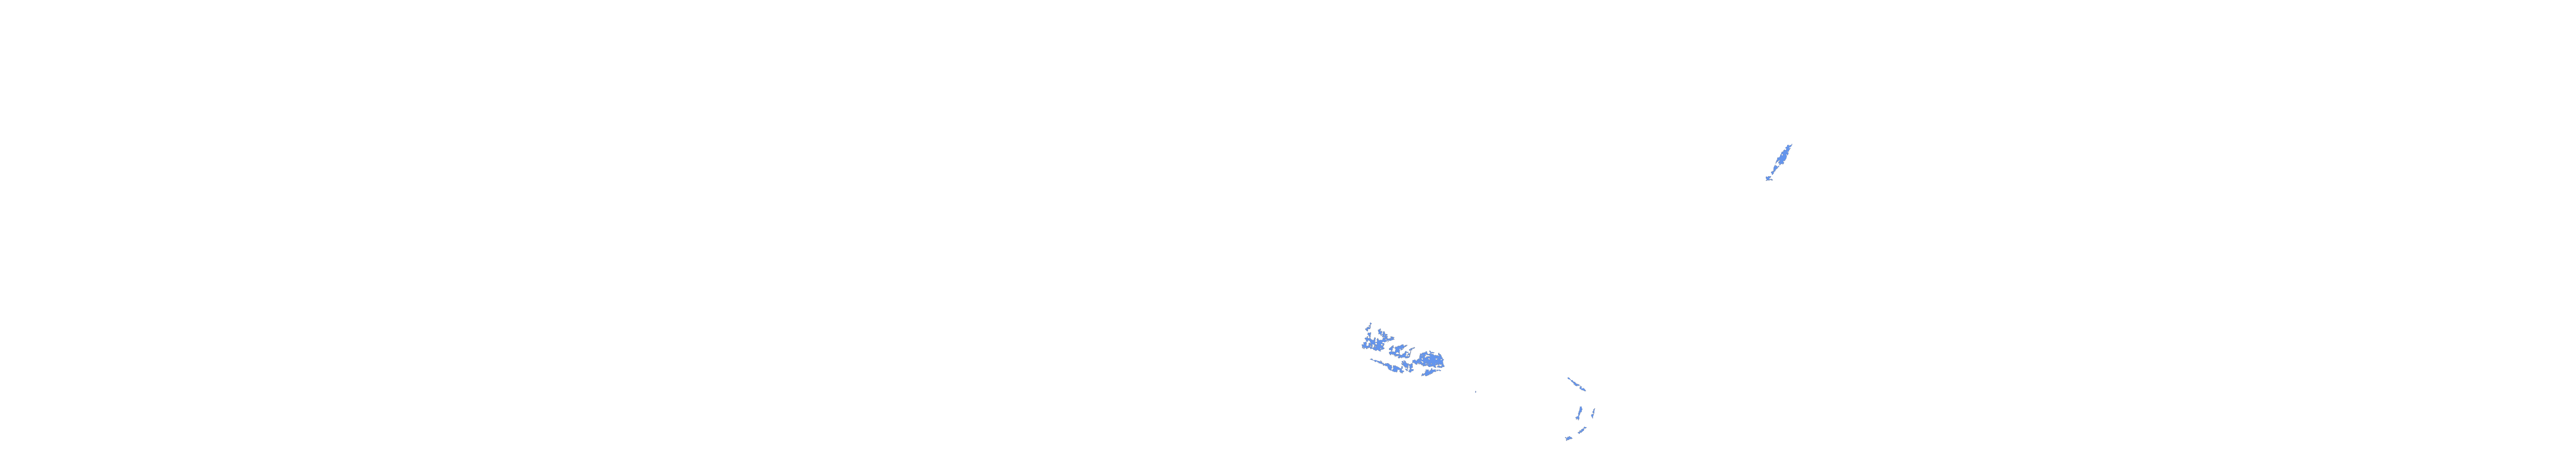
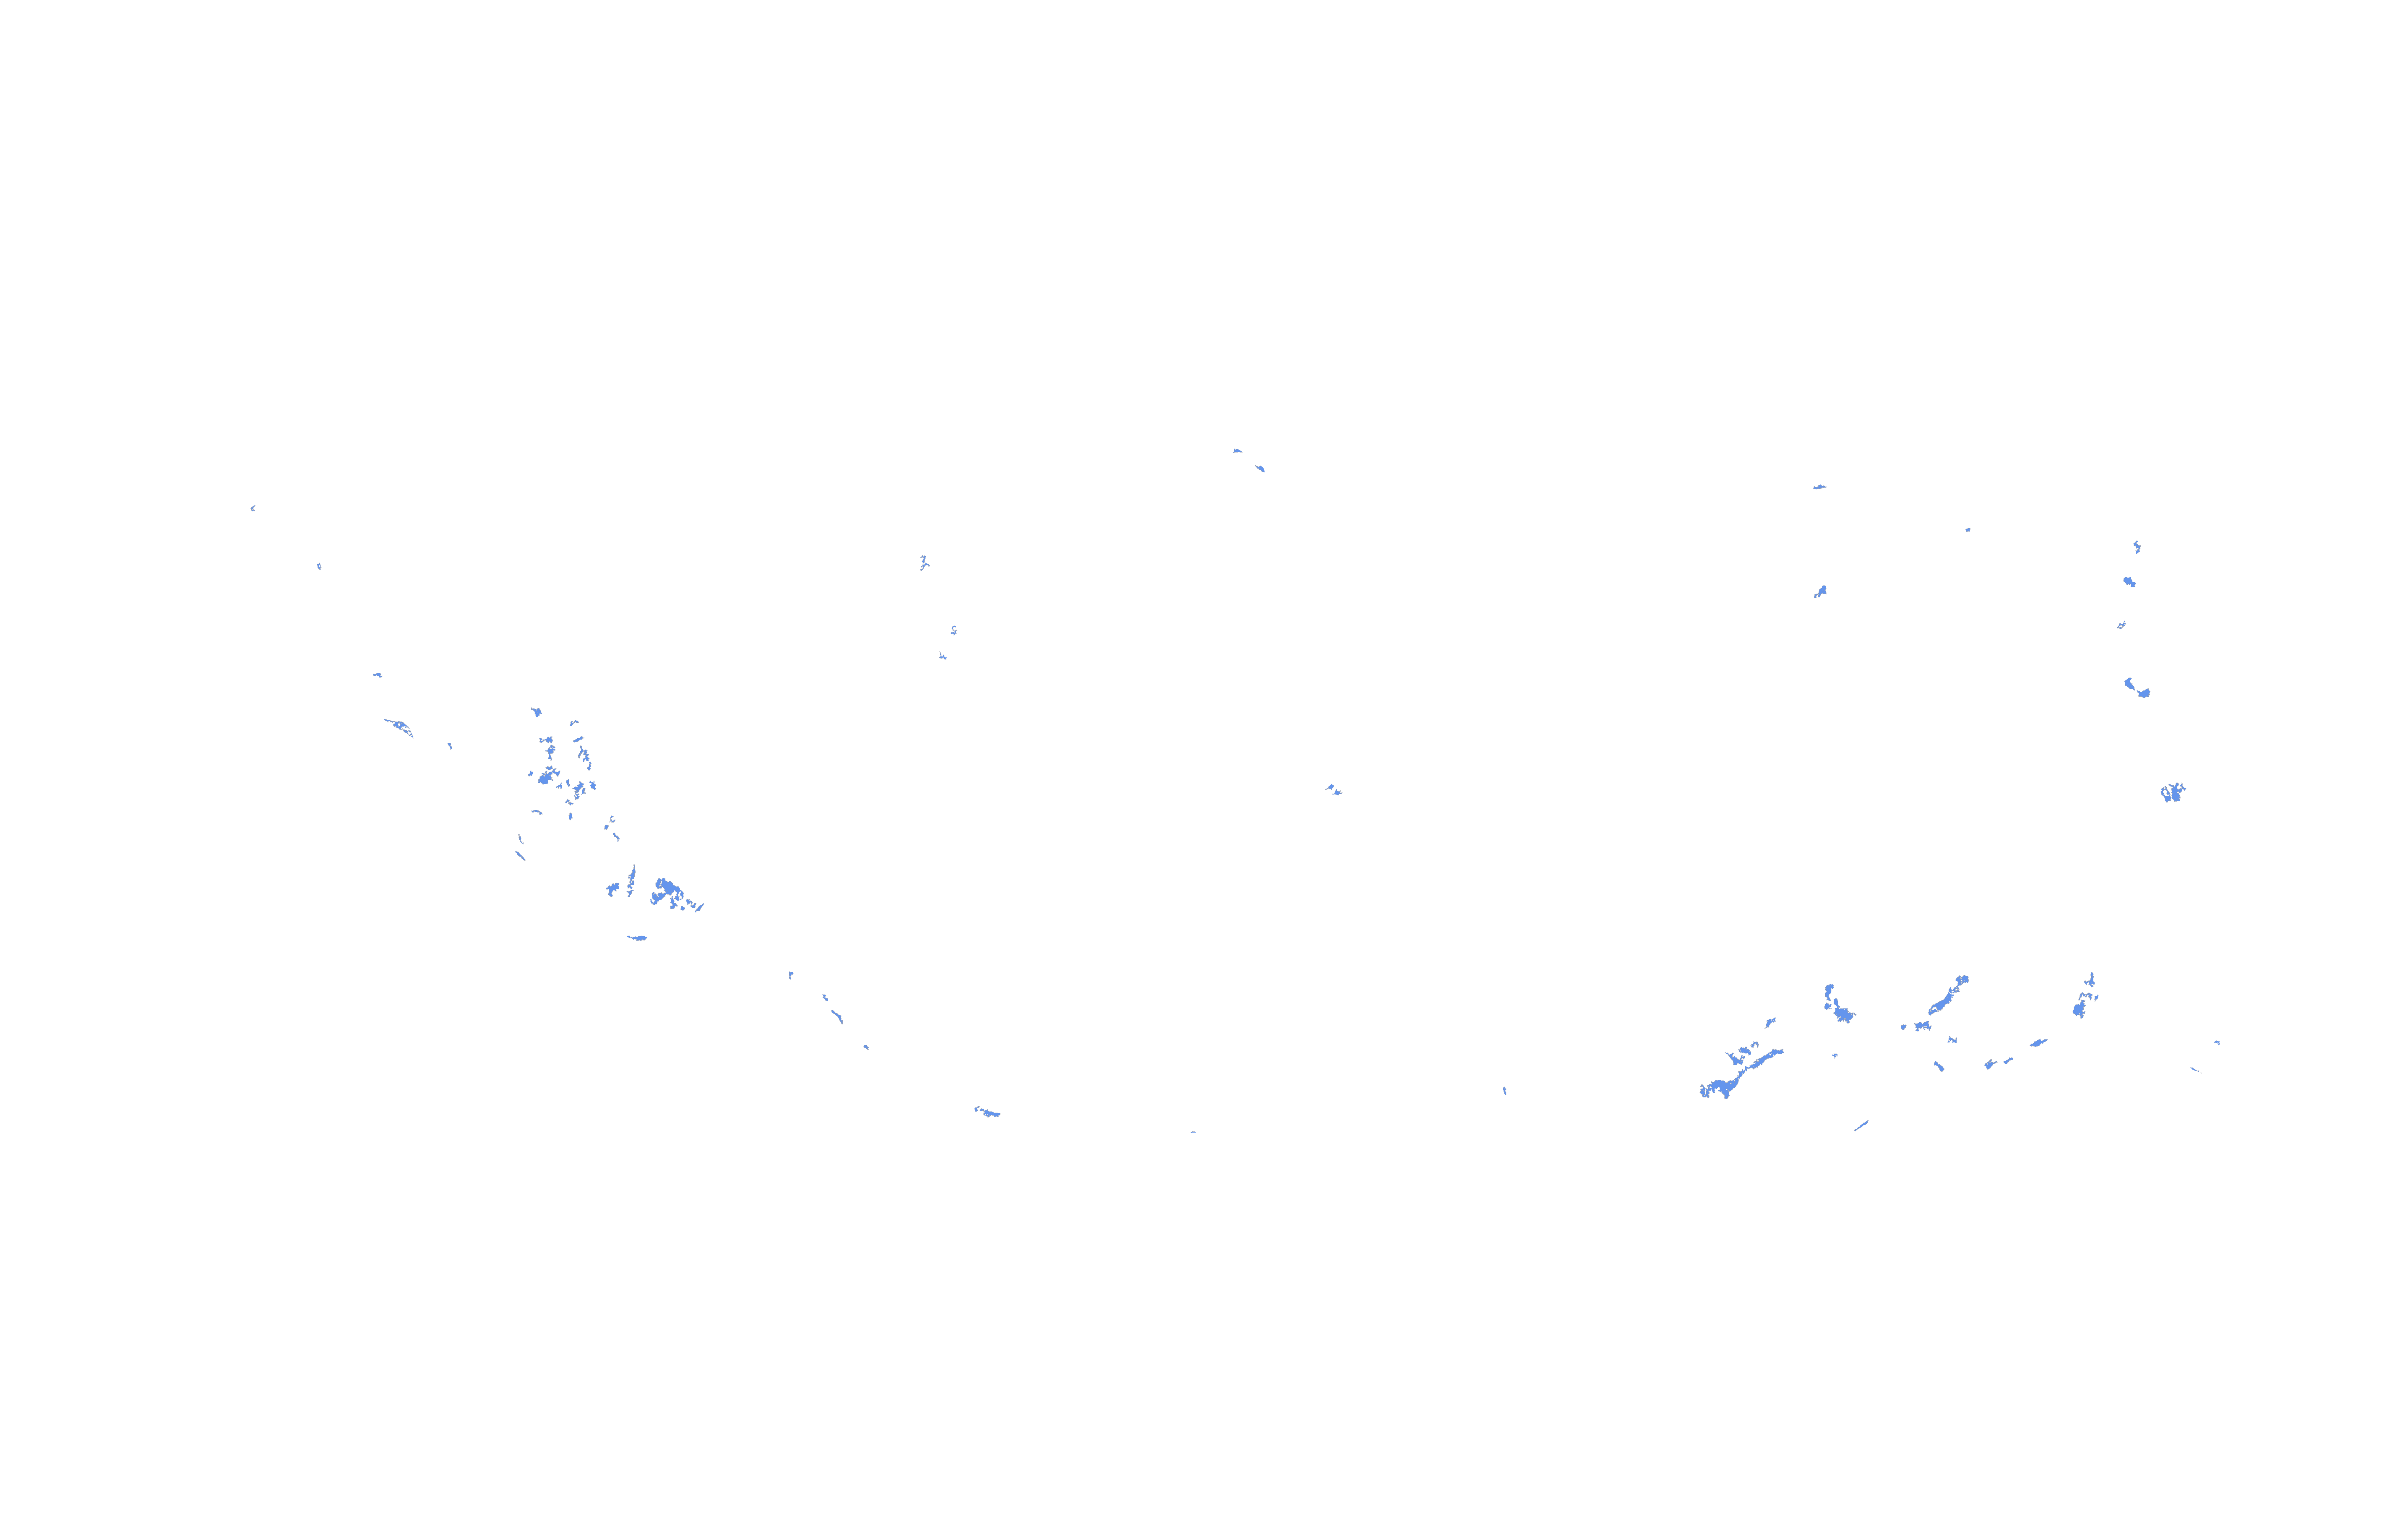
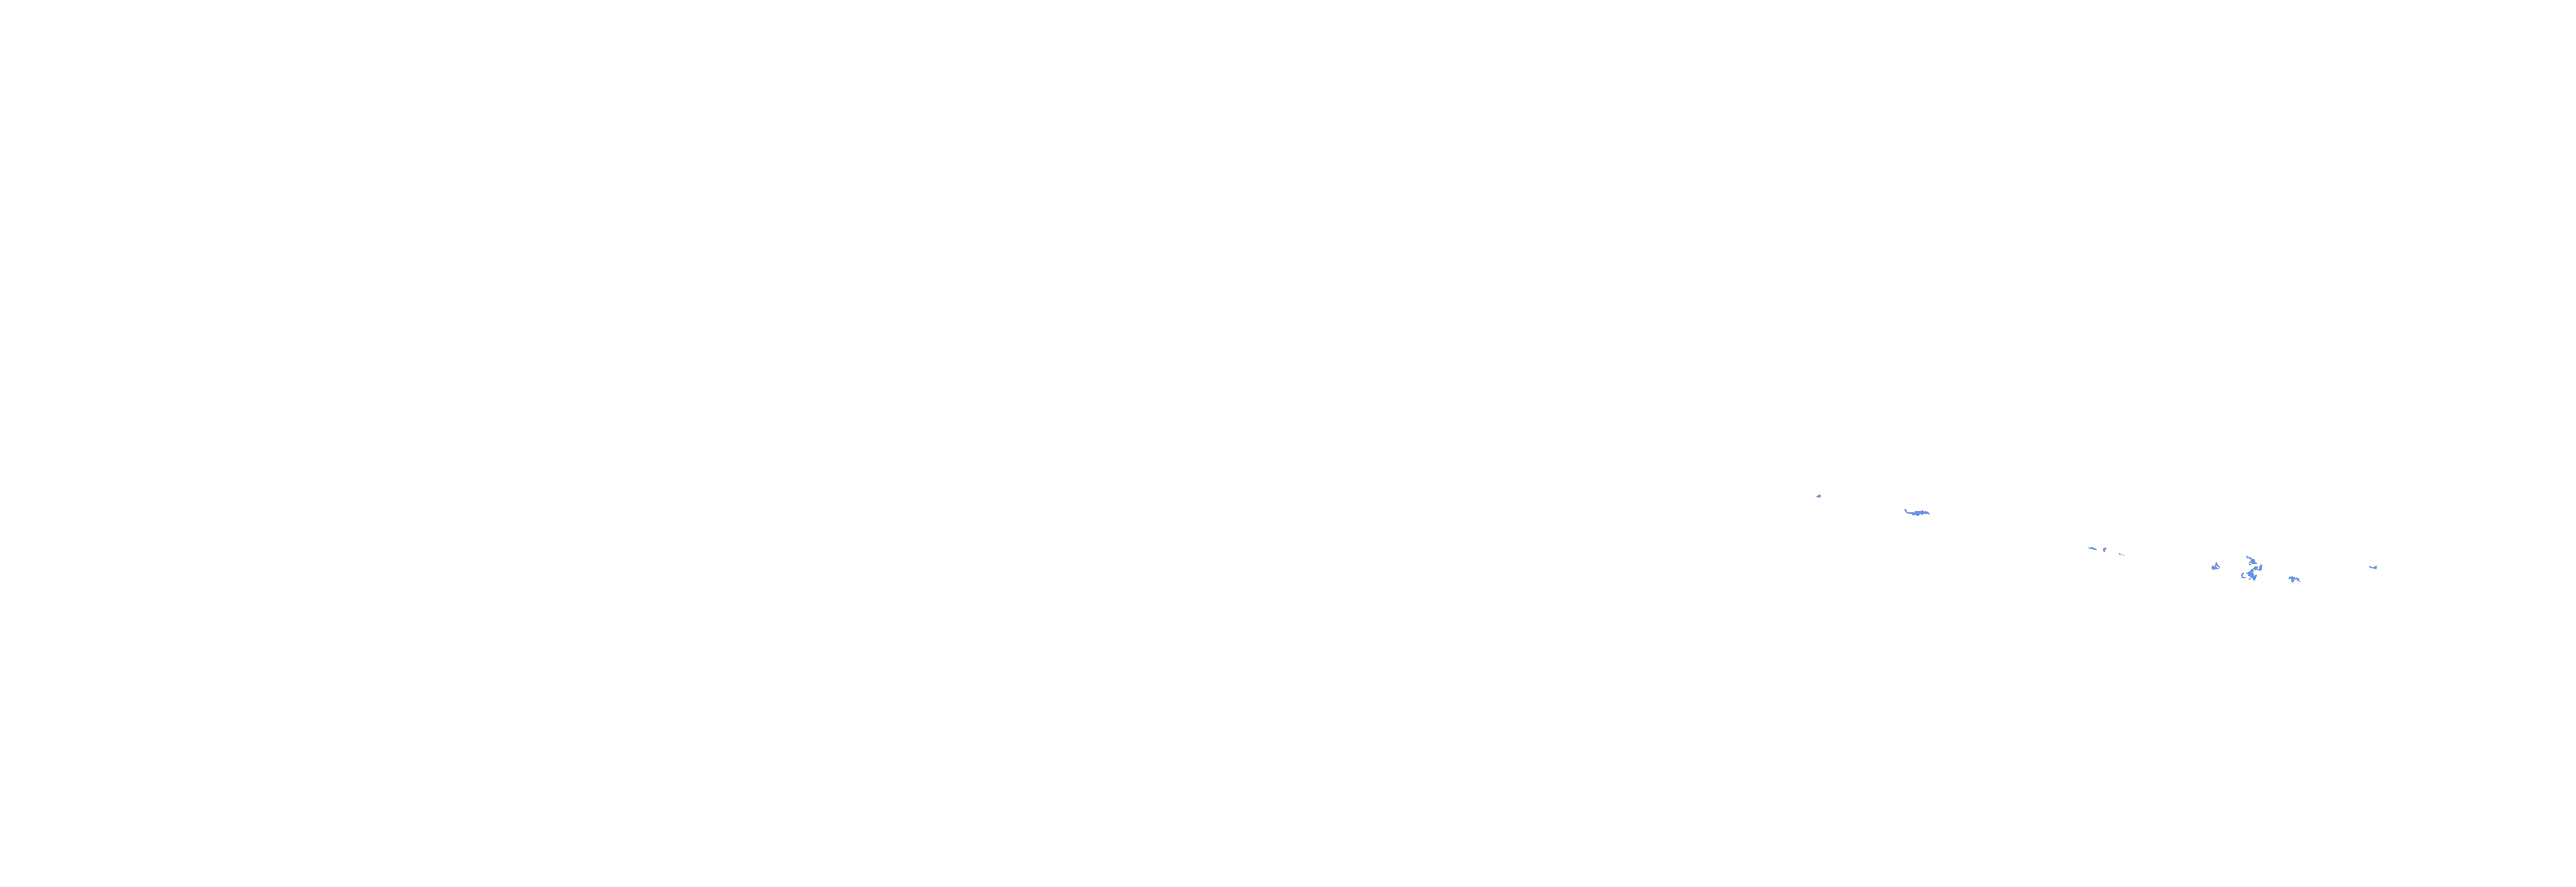
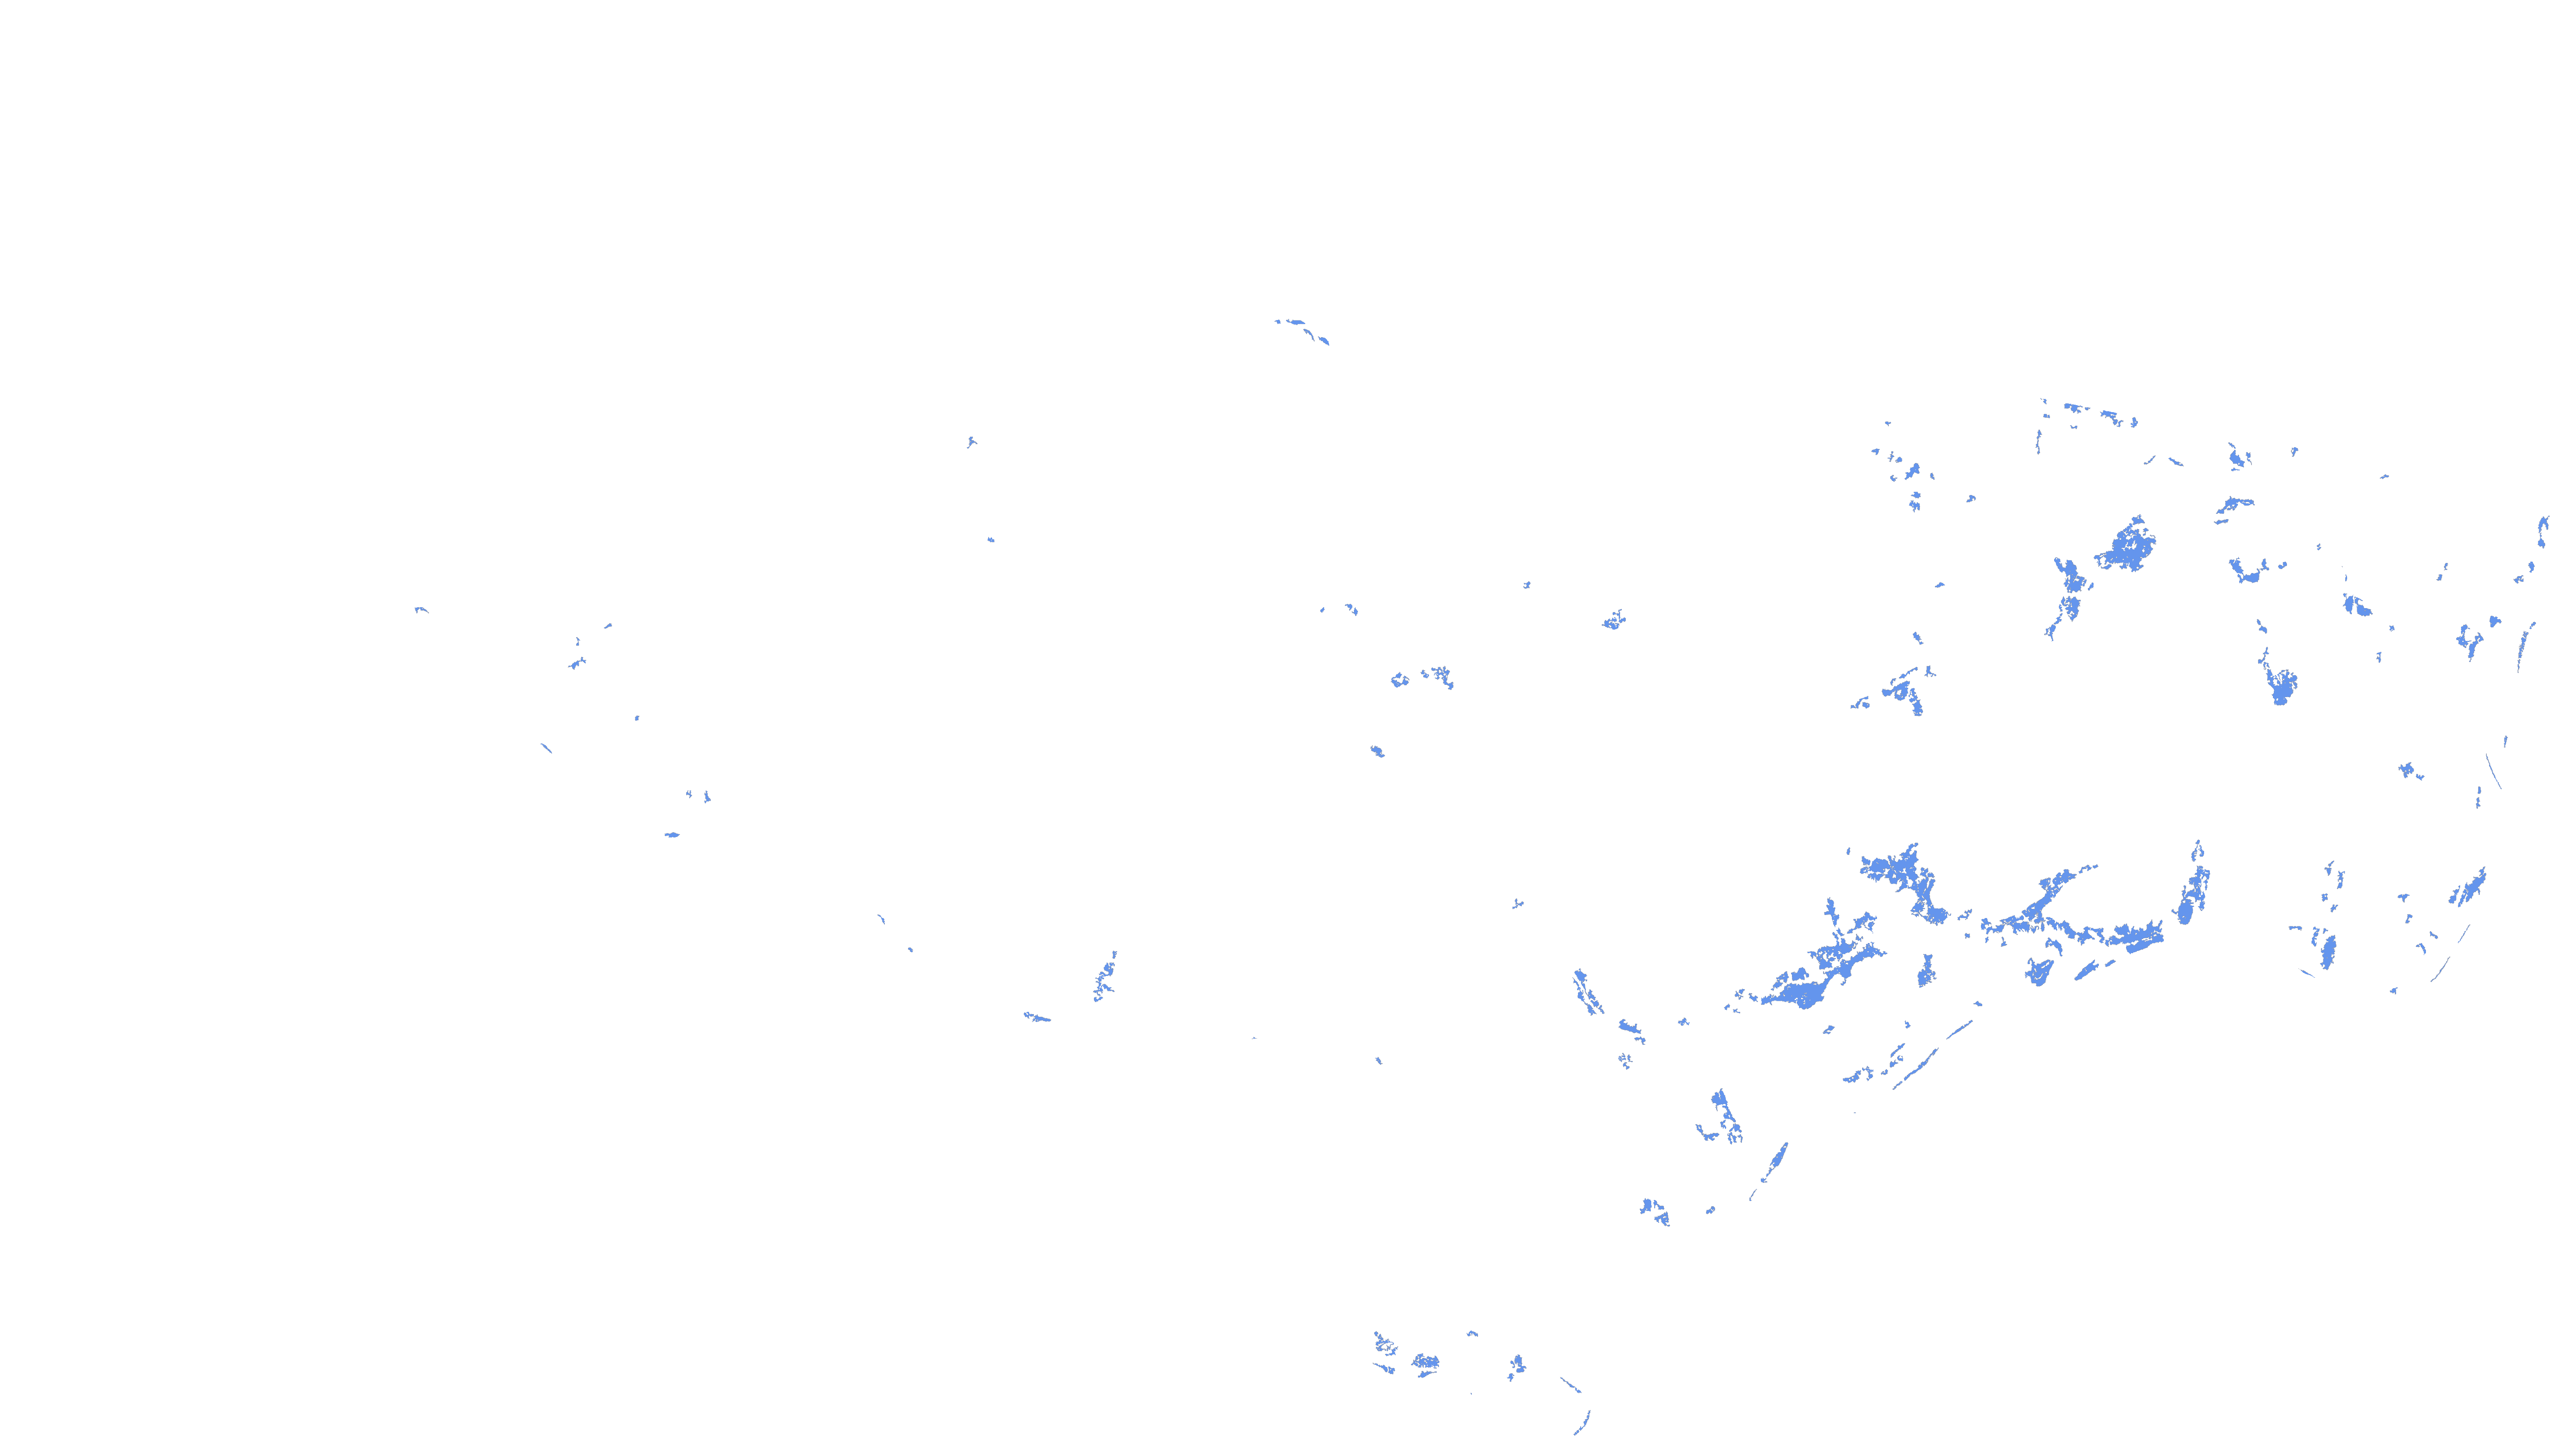

In [28]:
m

## Not super interesting?

Let's try layer 2, and 10 days.

In [34]:
rm(m)

In [35]:
gc()

used    (Mb) gc trigger (Mb)   max used  (Mb)  
Ncells 1811449 96.8   3247068   173.5   3247068  173.5
Vcells 2890735 22.1 139047482  1060.9 315252586 2405.2

In [36]:
m=leaflet() %>% addTiles()

In [37]:
myProducts=listAOIProducts(aoi_id=myAOIs$aoi_id[1], start_date=Sys.Date()-10, end_date=Sys.Date())
for(i in 1:nrow(myProducts)){
    print(i)
    filePaths=rGloFAS:::getSingleLayer(cell_code=myProducts$cell_code[i], aoi_id=myAOIs$aoi_id[1], layer=rGloFAS:::getLayerNumbers()["Observed Water Extent"])
    tifs=lapply(grep("tif$", filePaths, value=TRUE), rast)
    this_time=myProducts$product_time[i]
    tifs = lapply(tifs, function(tif) {
        v=vect(vte)
        masked=mask(tif, v)
        if(!any(!is.na(values(masked)))) return(NULL)
        return(crop(tif, vte, mask=T))
    })
    tifs = tifs[!sapply(tifs, is.null)]
    if(length(tifs)==0) next
    if(length(tifs)>1) tif = do.call(merge, tifs) else tif = tifs[[1]]
    limits=tif
    values(limits)[!is.na(values(limits))]=1
    values(limits)[is.na(values(limits))]=NA
    limits= as.polygons(limits, dissolve = TRUE)
    m=m %>% addPolygons(data=limits, color="red", weight=2, fillOpacity=0, group=this_time) %>% 
    addRasterImage(tif, colors=c("#00000000", "cornflowerblue"), group=this_time)
    gc()
}


[1] 1
[1] 2
[1] 3
[1] 4                                     
[1] 5                                     
[1] 6


HTML widgets cannot be represented in plain text (need html)
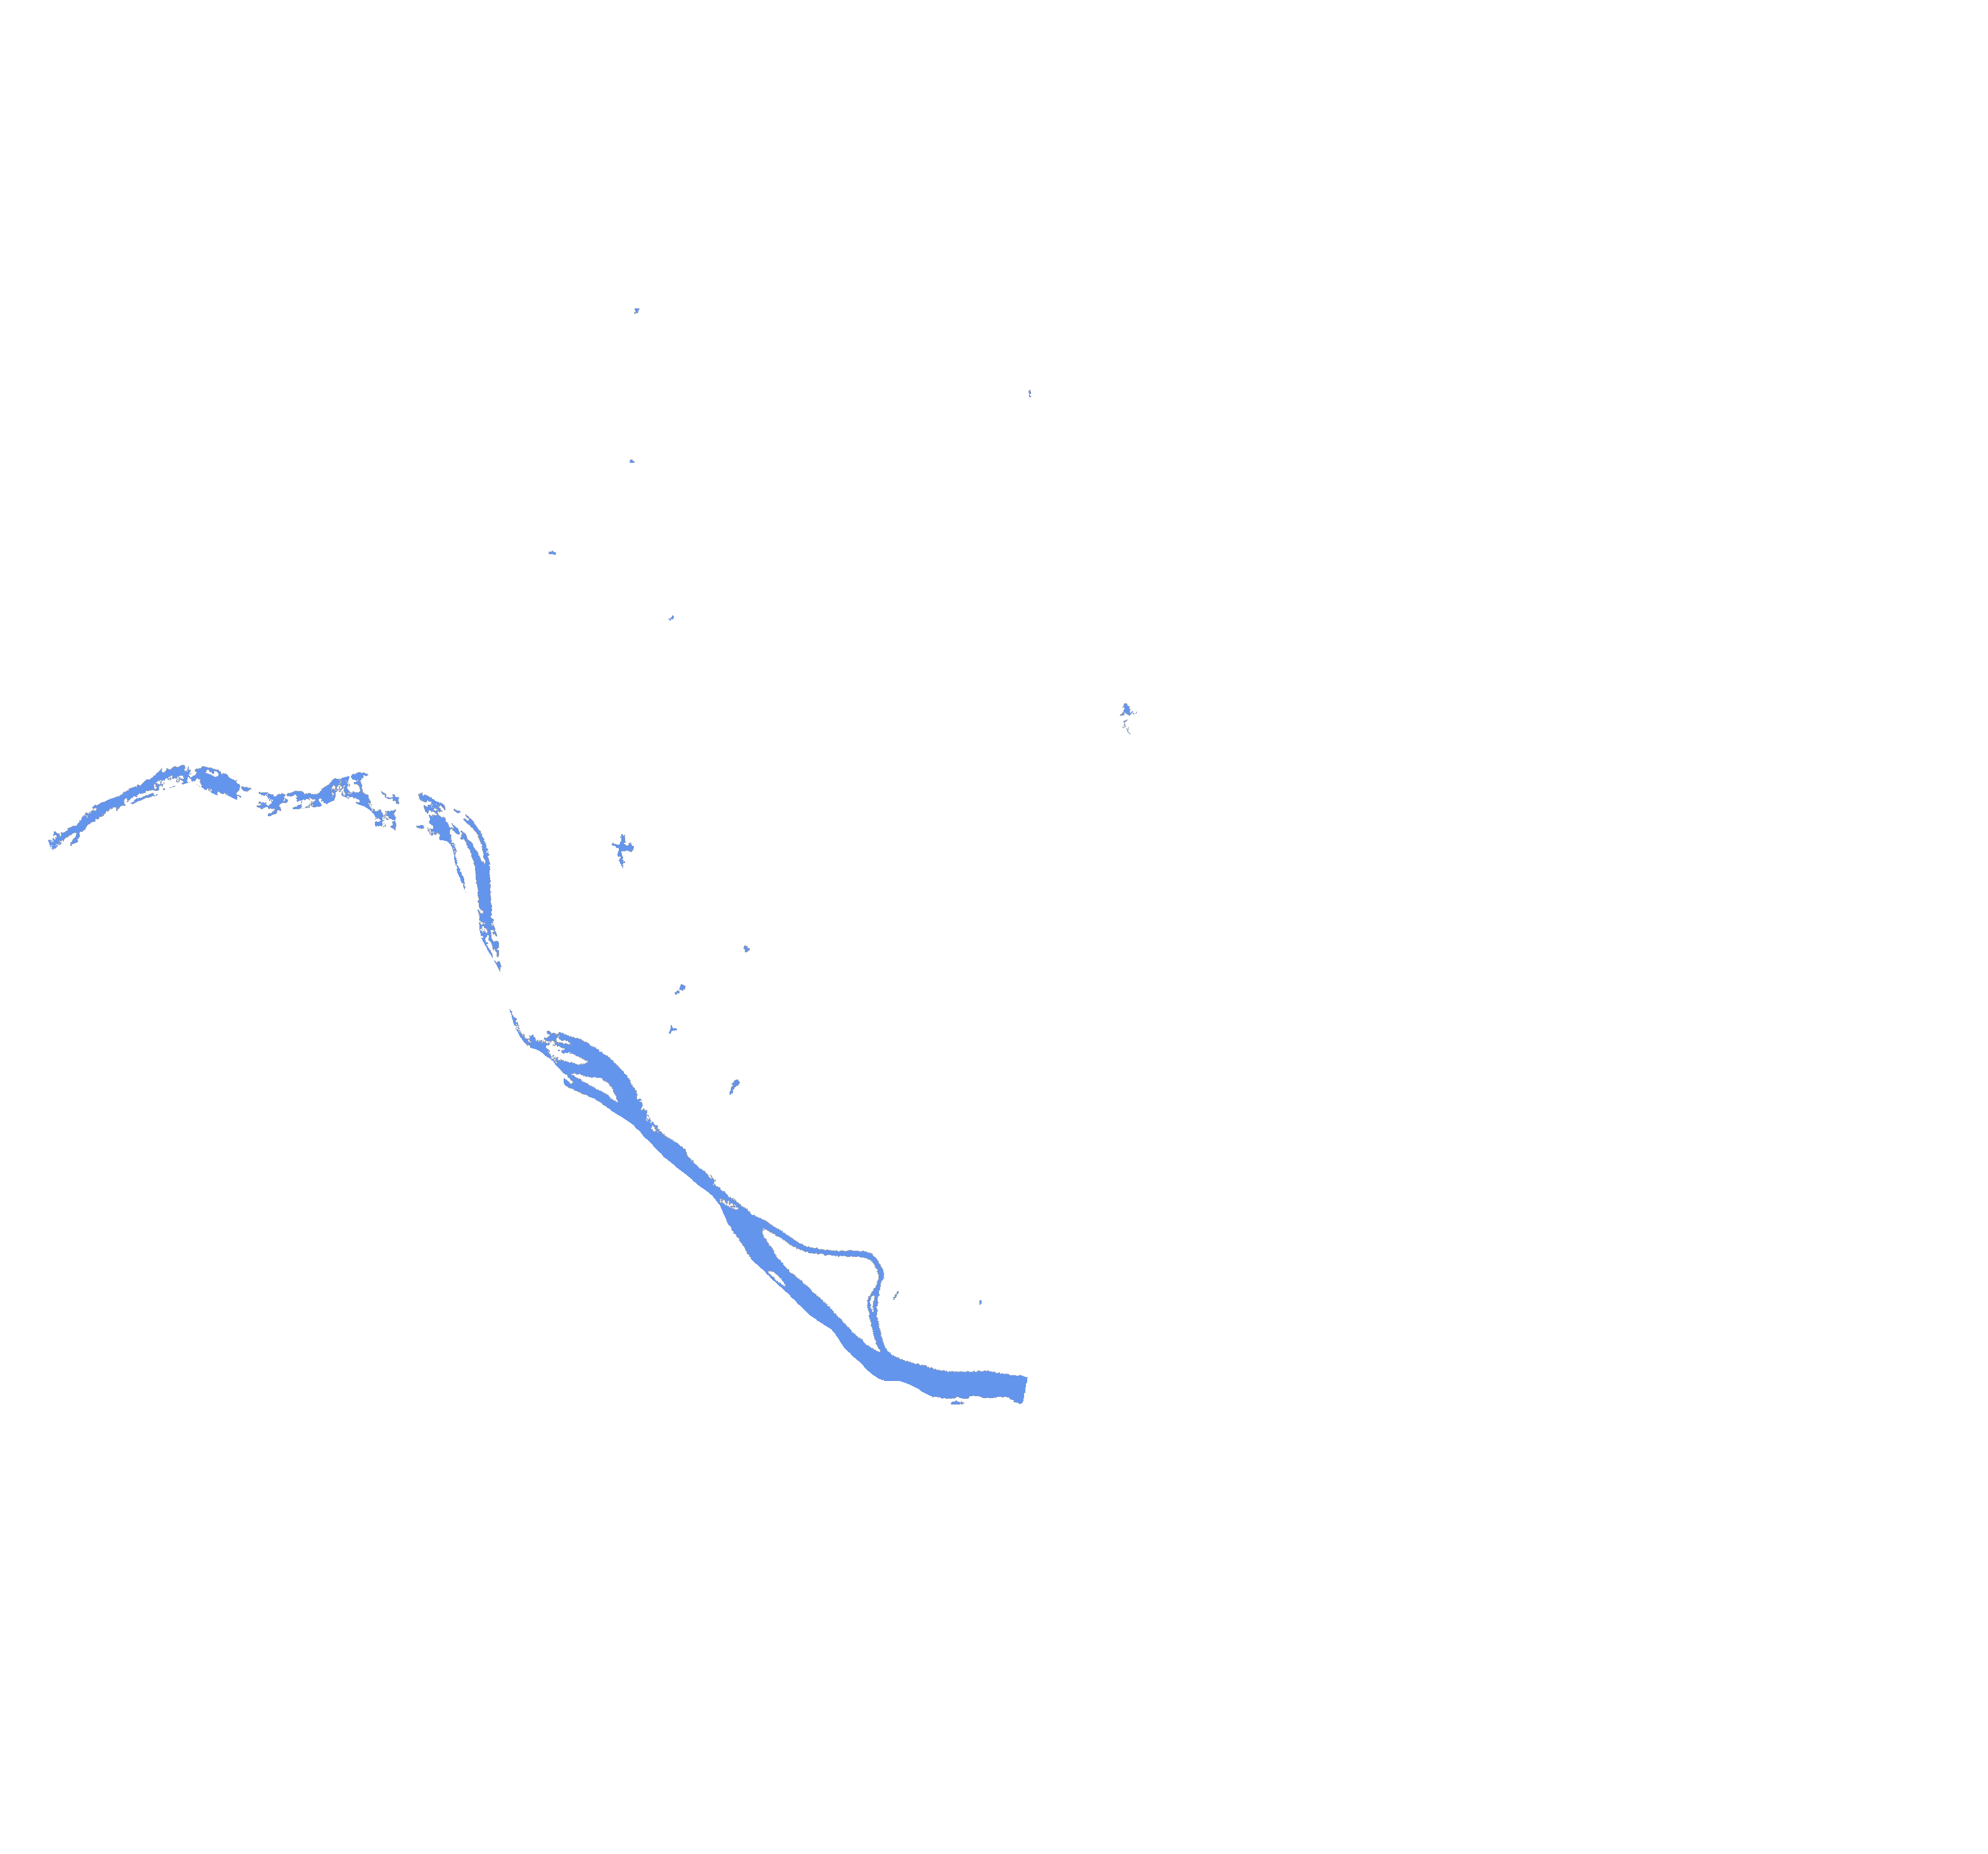
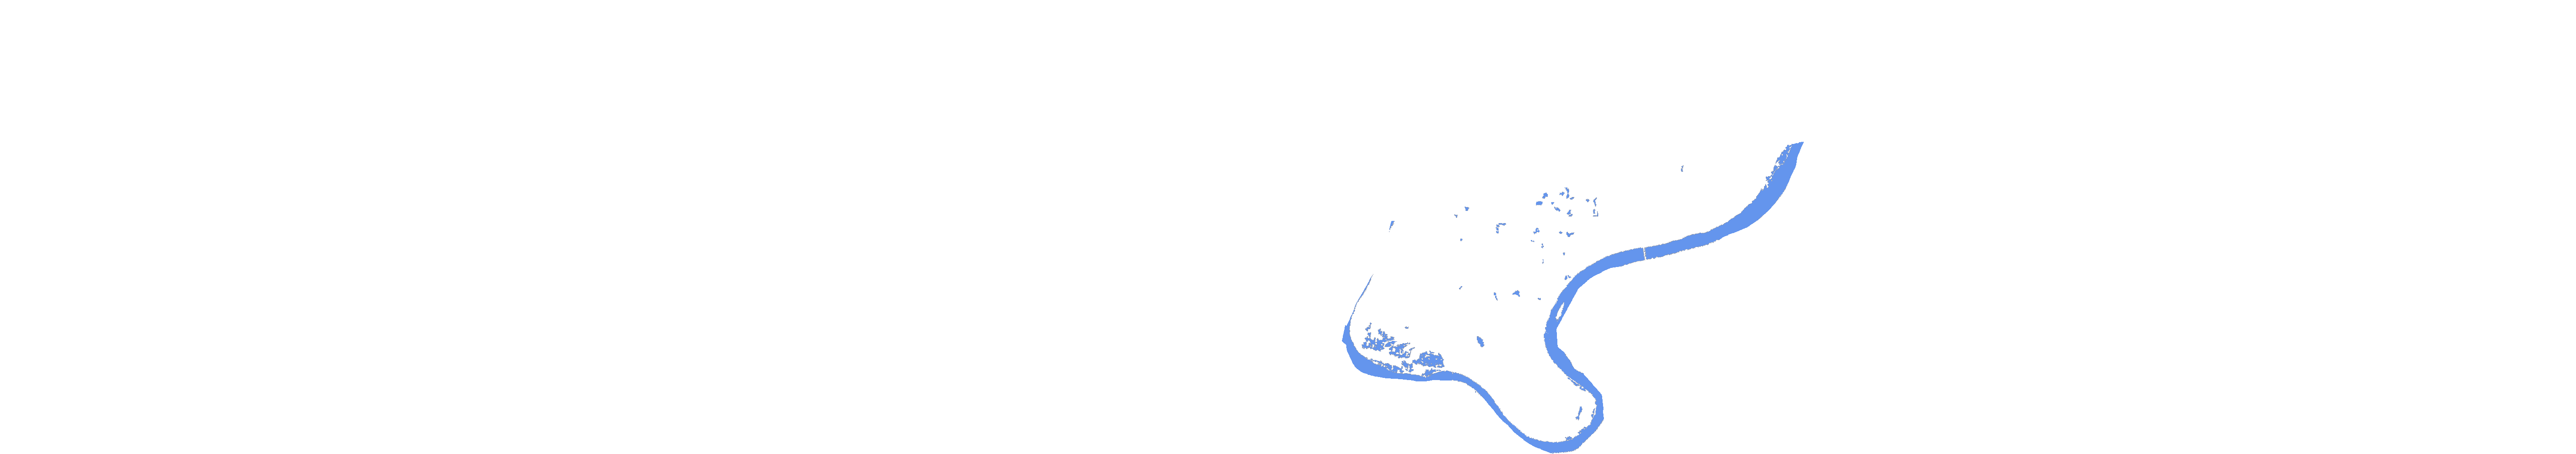
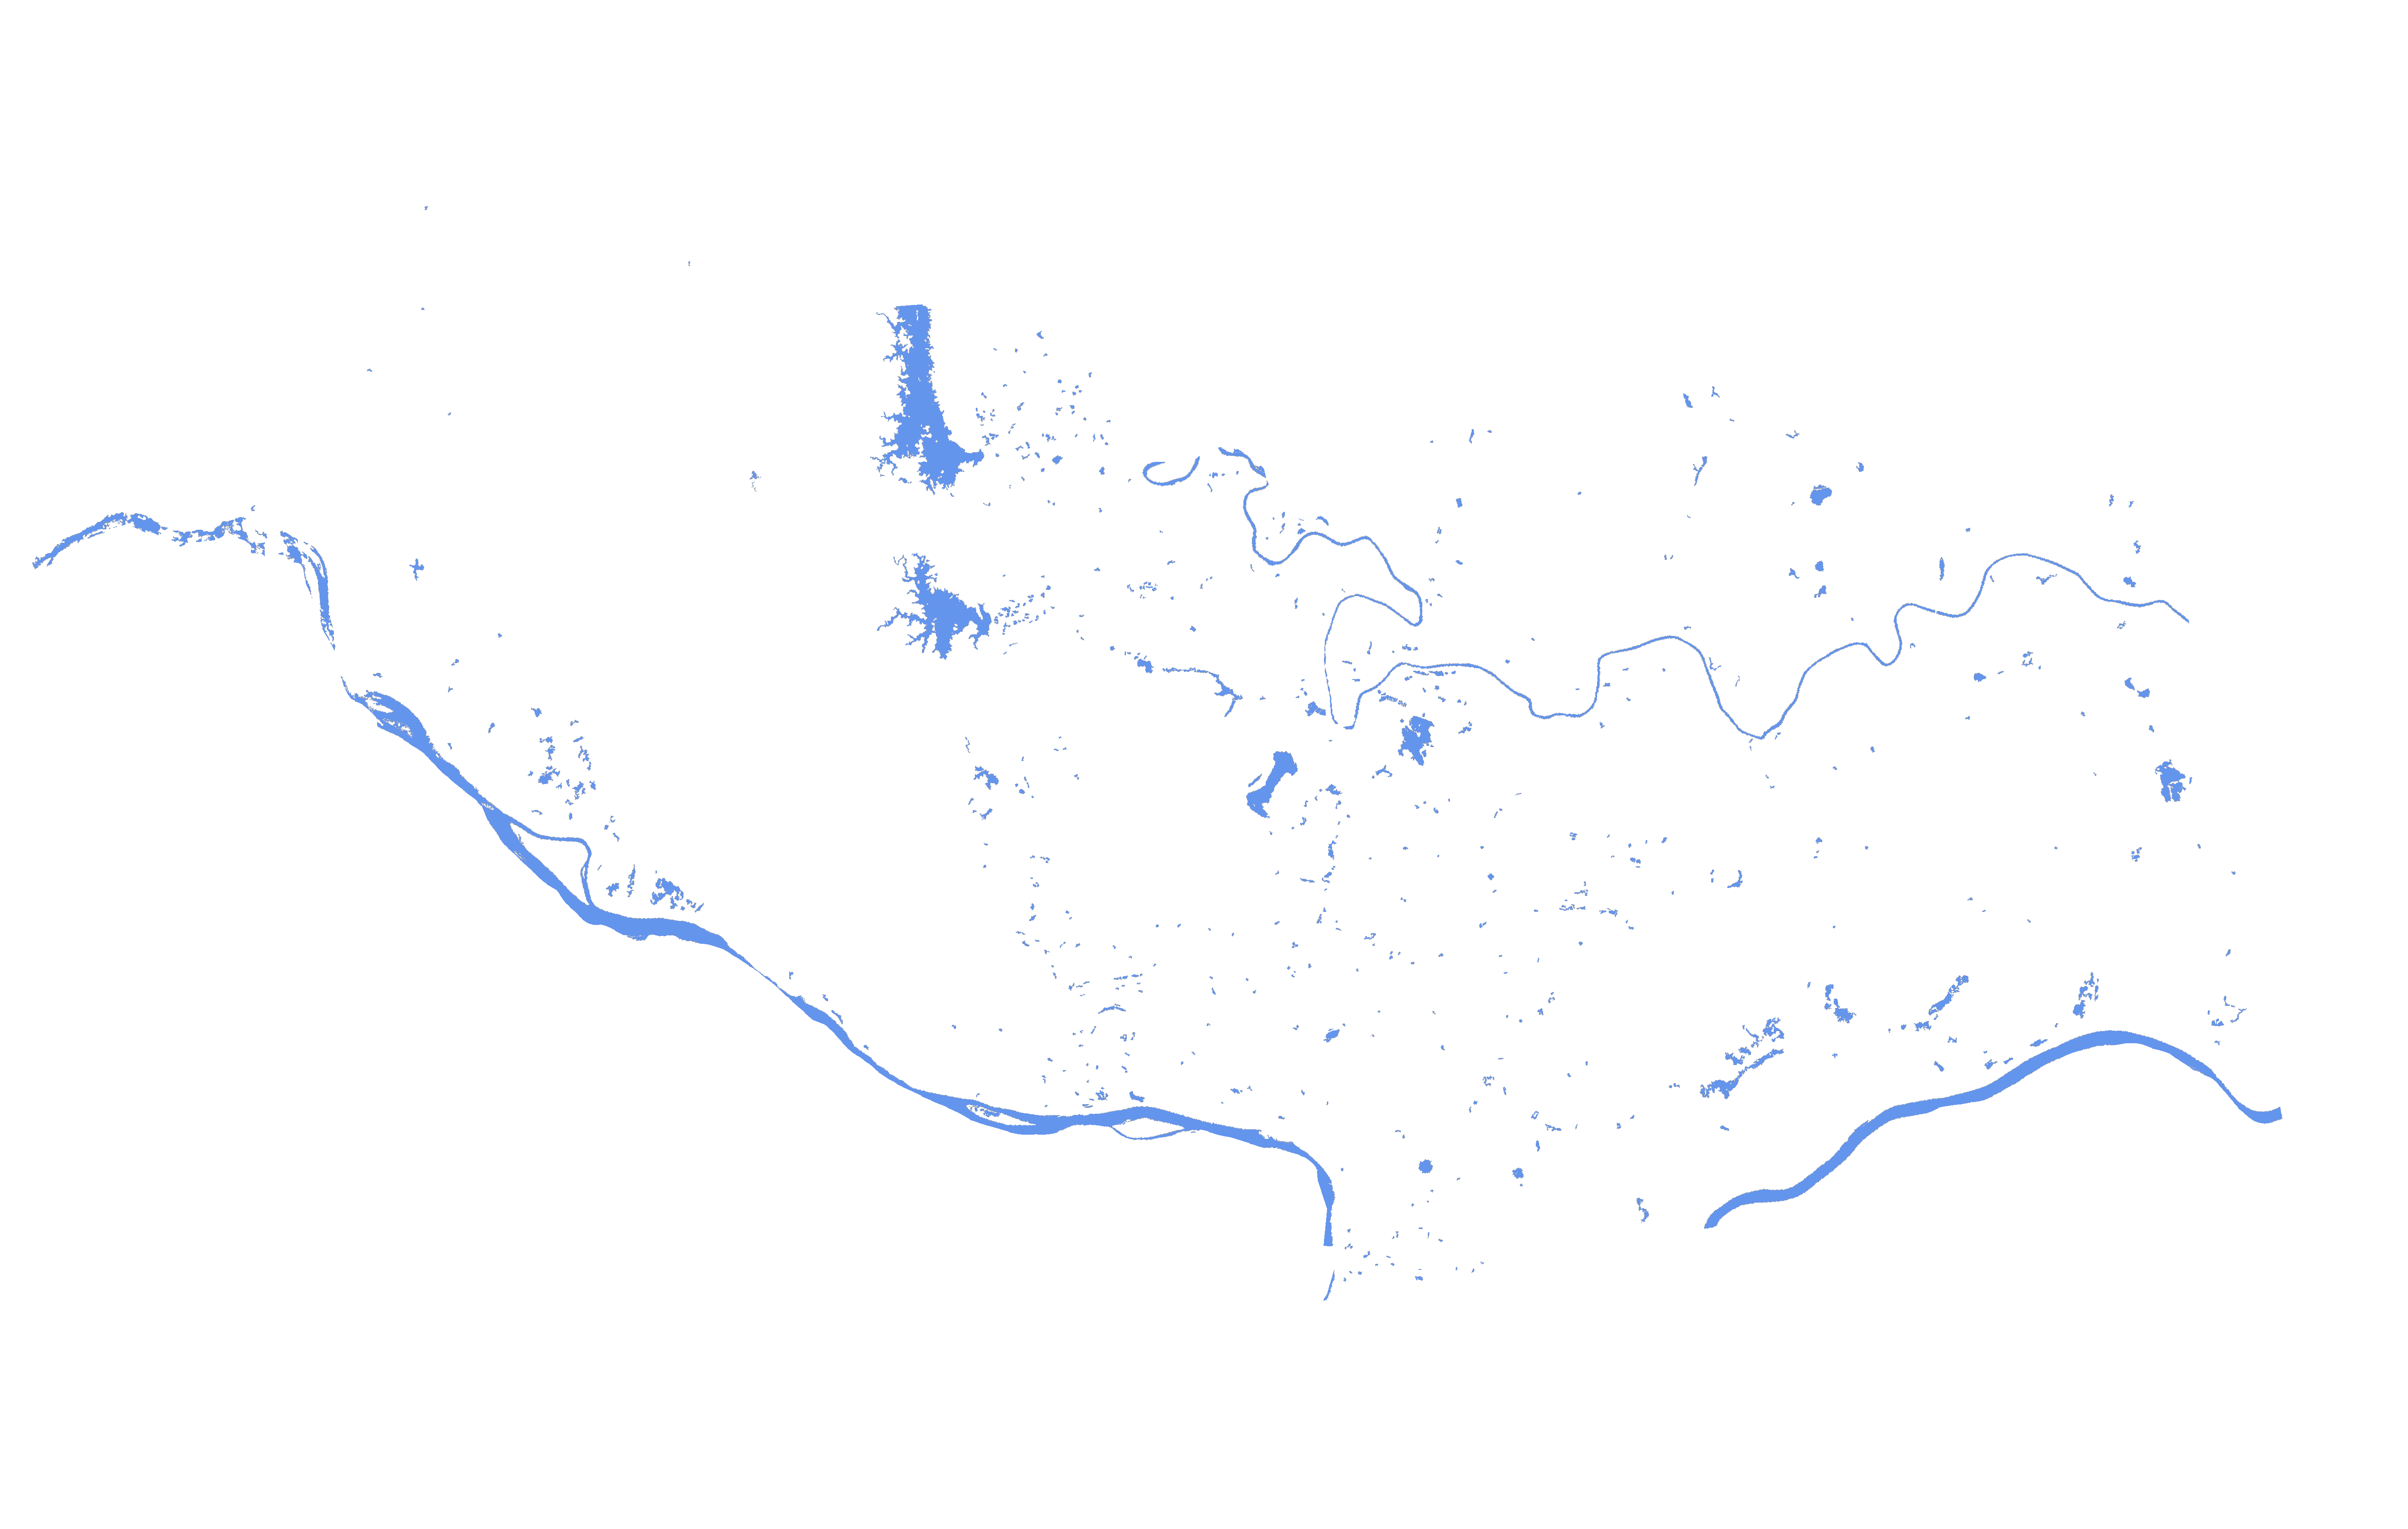
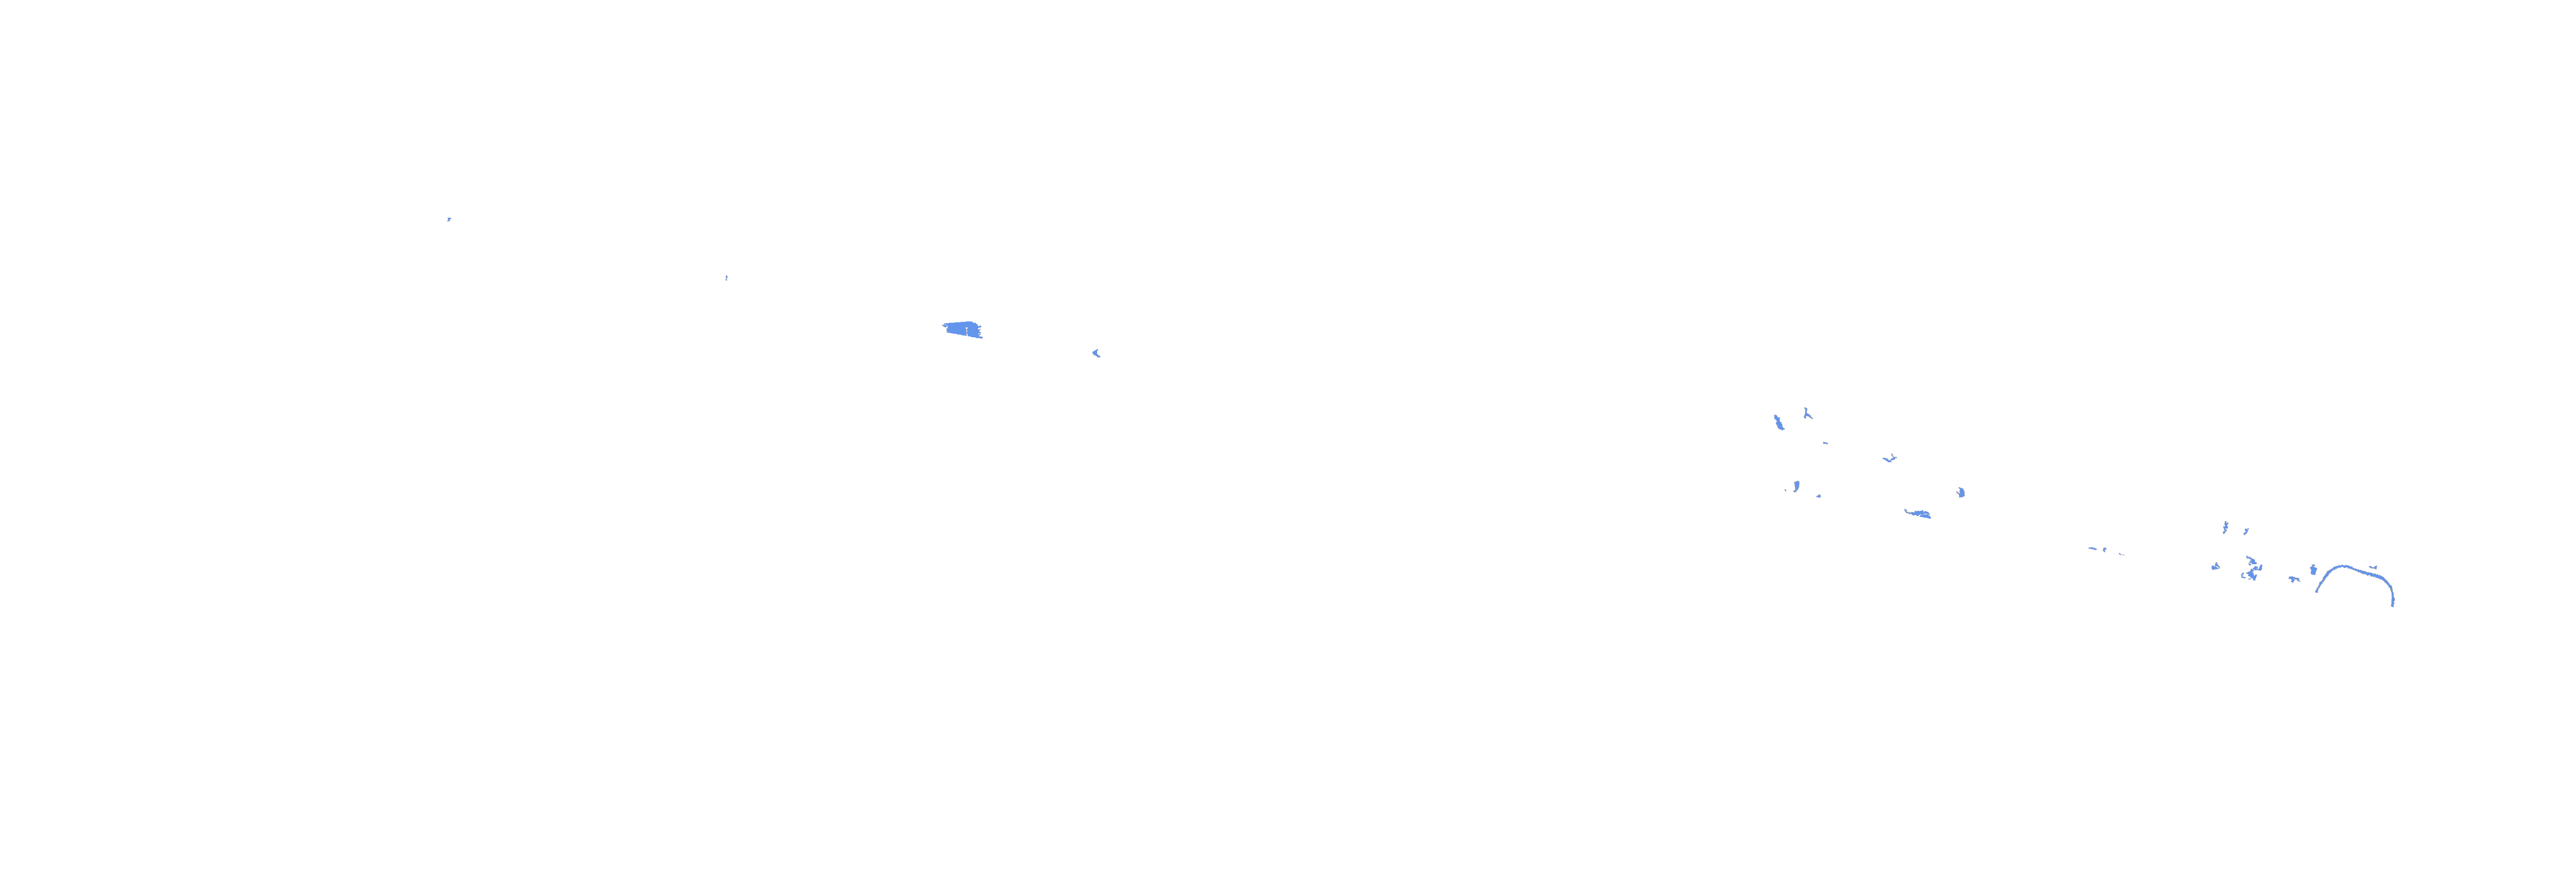
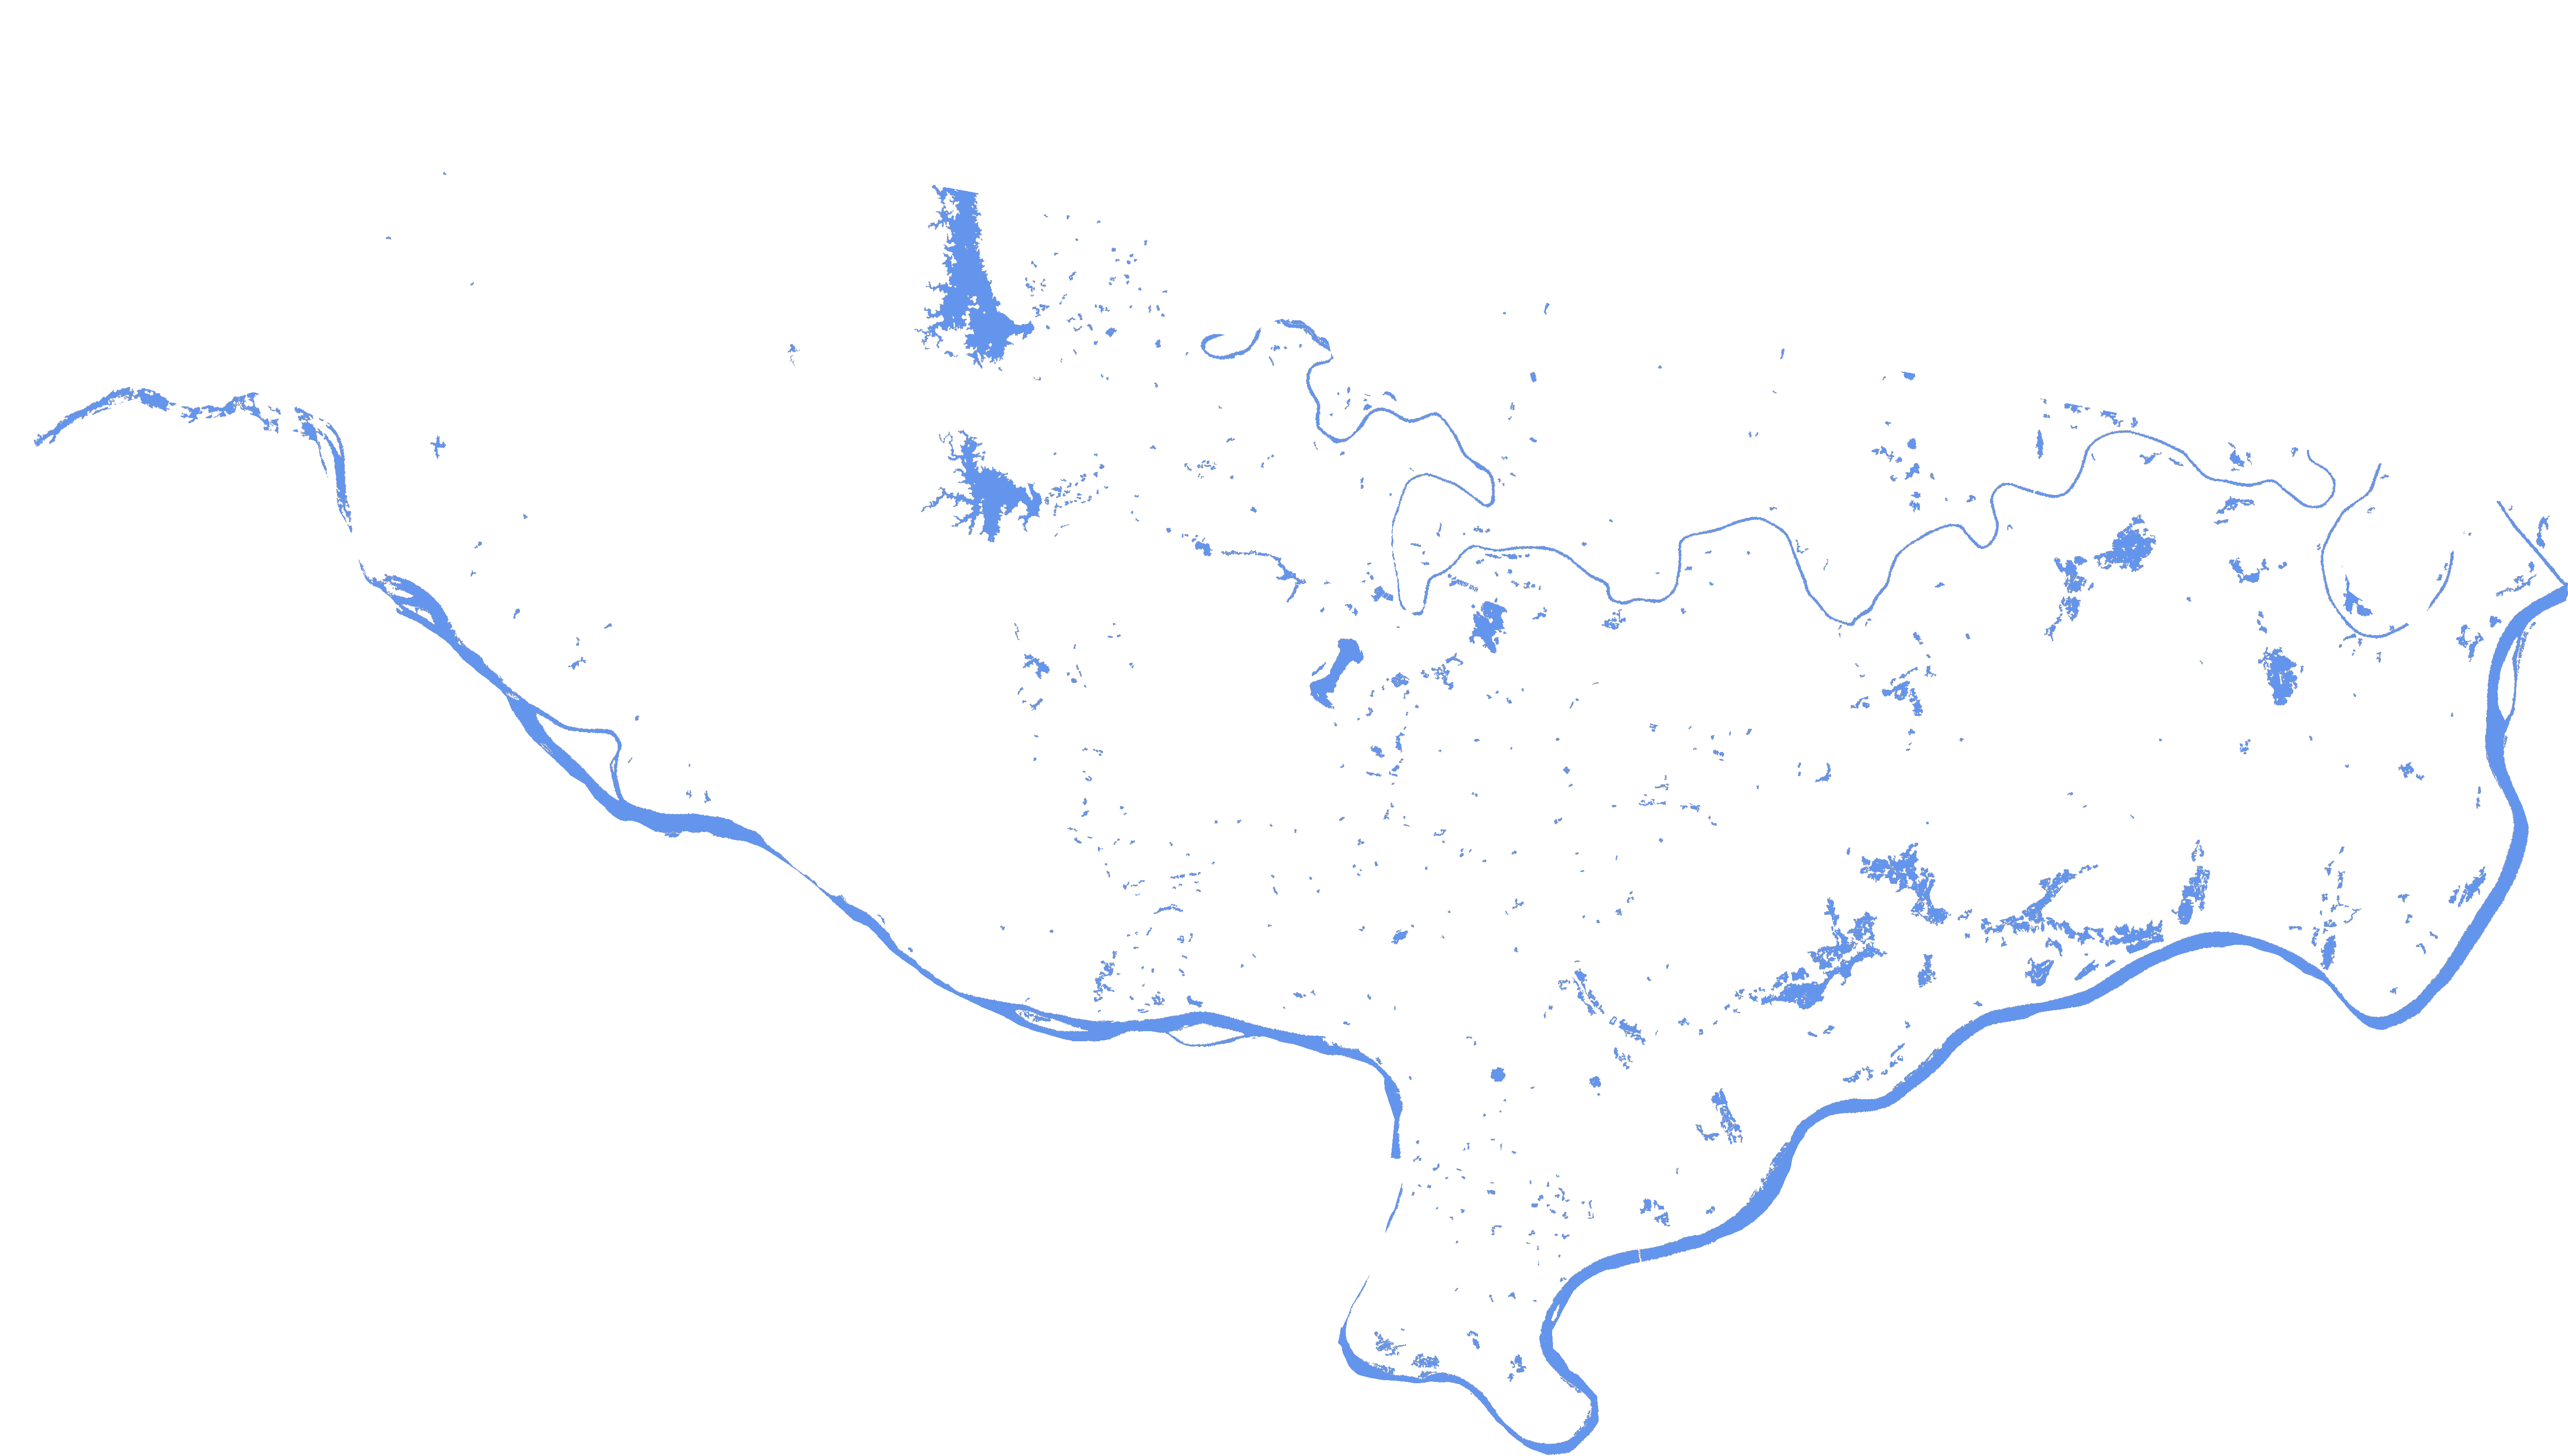

In [39]:
m=m %>% addLayersControl(
    overlayGroups = myProducts$product_time,
    options = layersControlOptions(collapsed = FALSE)
  )
m

In [40]:
library(htmlwidgets)
saveWidget(m, file = "leaflet_map.html", selfcontained = TRUE)


## Submitting an AOI

In [1]:
library(sf)
laoadm=st_read("~/notebooks/gadm41_LAO_2.shp")


Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 8.2.1; sf_use_s2() is TRUE



Reading layer `gadm41_LAO_2' from data source 
  `/home/agilly/notebooks/gadm41_LAO_2.shp' using driver `ESRI Shapefile'
Simple feature collection with 142 features and 13 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 100.0868 ymin: 13.90968 xmax: 107.635 ymax: 22.5004
Geodetic CRS:  WGS 84


In [ ]:
laoadm=laoadm[laoadm$GID_1=="LAO.13_1",]


Warning message:
“st_centroid assumes attributes are constant over geometries”


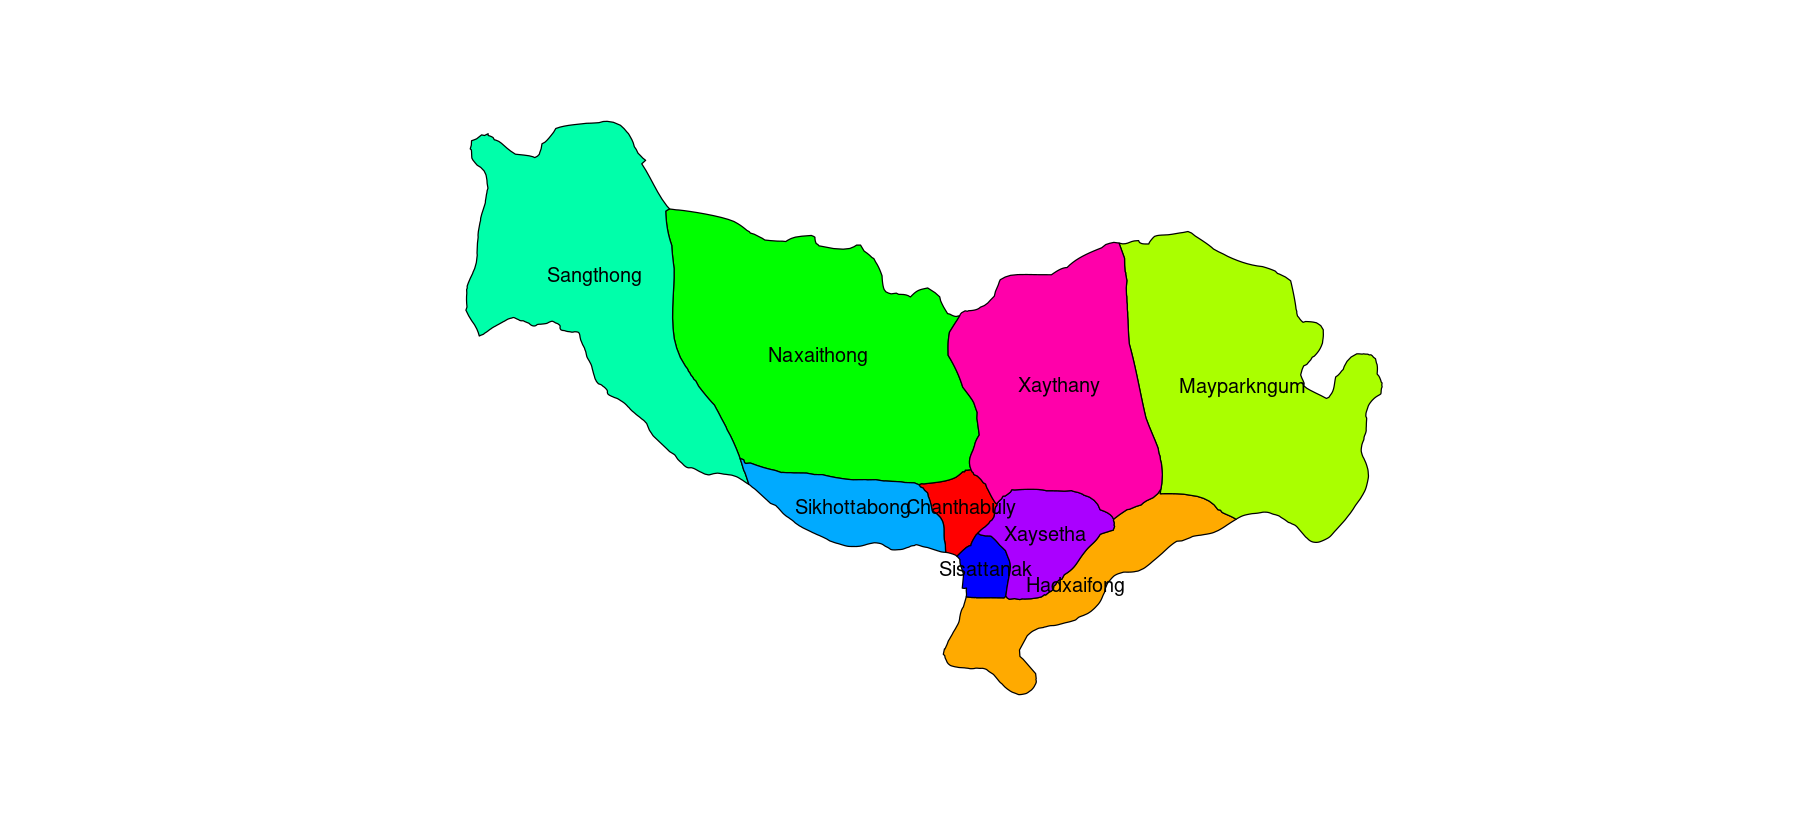

In [23]:
options(repr.plot.width=15)
# Assuming laoadm is already loaded as an sf object
# Specify the column to color by and the column for names
color_column <- "NAME_2"
name_column <- "NAME_2"

# Define a color palette
unique_names <- unique(laoadm[[color_column]])
colors <- rainbow(length(unique_names))
color_map <- setNames(colors, unique_names)

# Plot the polygons, coloring them according to the specified column
plot(st_geometry(laoadm), col = color_map[laoadm[[color_column]]], border = "black")

# Calculate the centroids of the polygons
centroids <- st_centroid(laoadm)

# Extract coordinates for centroids
centroid_coords <- st_coordinates(centroids)

# Add the names to the plot
text(centroid_coords[,1], centroid_coords[,2], labels = laoadm[[name_column]], cex = 1, col = "black")


In [24]:
selected_names <- c("Sisattanak", "Xaysetha", "Hadxaifong")

# Filter the sf object to include only the specified names
selected_areas <- laoadm[laoadm$NAME_2 %in% selected_names, ]

# Compute the union of these geometries
union_geometry <- st_union(selected_areas)


In [26]:
library(geojsonio)


Attaching package: ‘geojsonio’


The following object is masked from ‘package:base’:

    pretty




In [37]:
geojson=geojson_list(union_geometry)
attr(geojson, "class")= "list"

In [64]:
devtools::load_all("../..")

ℹ Loading rGloFAS


In [45]:
createAOI(aoi_name = "South VTE", description = "Sisattanak, Xaysetha, Hadxaifong", geoJSON = geojson)#, region = "LAO")

Response [https://api.gfm.eodc.eu/v2/aoi/create]
  Date: 2024-09-21 16:32
  Status: 201
  Content-Type: application/json
  Size: 79 B
{"aoi_id": "932f09c5bc6cb63e37b900d63427d3bb41d1b078db08b0febb59d90136bb683e"}


ERROR: Error in genericGloFASAPICall("aoi/create", method = "POST", body = body, : API call failed. Please check your request.


In [46]:
listUserAOI()

aoi_id                                                           aoi_name 
1 7fe2575d441a24ef38b4f00d9d3bfa1107835402ad5074b6ce6d115496af3aa6 Laos     
2 932f09c5bc6cb63e37b900d63427d3bb41d1b078db08b0febb59d90136bb683e South VTE
  description                      geometry                      
1 Lao PDR                          POLYGON ((102.7108 17.37431...
2 Sisattanak, Xaysetha, Hadxaifong POLYGON ((102.6066 17.95358...

In [48]:
flext=orderMaxFloodExtent(aoi_id = "932f09c5bc6cb63e37b900d63427d3bb41d1b078db08b0febb59d90136bb683e", start_date = Sys.Date()-15, end_date = Sys.Date())

In [49]:
flext

$order_id
[1] "20a7231ec93b80b132d6e9029f64d30a"

In [51]:
checkMaxFloodExtentOrderStatus(order_id = flext$order_id)

$order_id
[1] "20a7231ec93b80b132d6e9029f64d30a"

$status
[1] "finished"

In [52]:
listAOIProducts(aoi_id = "932f09c5bc6cb63e37b900d63427d3bb41d1b078db08b0febb59d90136bb683e", all=T)

product_id                                                      
1    7eef65c8df850699d5b473ba00d2a0db95d920f5411e46273eee03a82e520623
2    65ed6c5889a5dd77f0416424edded941fedccfb3ce6f0b61e2b77ce1167adb0c
3    4fe80d3ac0caa8ed151a90f611e088d6930337e83636368d12bc19b0ba3d7d5e
4    392c8c5d963d66225399045670d2015d545f7874137c40a21e5467fcab4ca14f
5    5aaa8909a7c2a17831fd8836fe340f02138a8e41056cfa8ee004c8954dbf870b
6    1da32e37e279eaaa76c57ffbc19fa9f914ae6d377f31e44835d202c6f5783d7b
7    36613903d9a4fe2a0e4cef17a5e0fbb2c426f080af09b3e0ef5d1c0e67f20bc7
8    5464e33f499130f19815c6c212dc9eed4d3b418a4965461a23844c6190d79e0b
9    6474498938d362798e0c223bcaa9a23848d8854a0423b2db36b0684d641ec73e
10   076810093a1f2e769a0ade0fc5b20efc8d2709c786d3aaa0d285d87b9e246ffd
11   5a3c2f0b46af52e87f33174aacdfa5c64609d53a5d76bac0ceb70b0415729b9d
12   0667fed74c762f52cb0fb586229309130ef5636fb9aba95658d1756dc7cf5d5a
13   73e86e9b6f5ec4e5dd323822443229700ceabe5ace7fe4d58f376fe4f1aff2b5
14   1585b7a1375506fcaac1d9d96a6aabe2d7c0490c2dd5c98d8c8cc2259e2a8605
15   82de9fa3bb233eece7fdb4114e5f30539c80714307cb4d1d9ef8deac1cd753b5
16   38836ceaffda645aba8fcd449c348f4c09703b9f1bbb57ca271aa9a4944d35af
17   9d606a5b9fbaeb7ebd859cc5971dd00794f1406c1660b27bb31345df45c1ff8b
18   51887bb63ccecf8237a4e40aee64e8e5a0048f415db37dc2723a369709882b10
19   09ebf3e76668667ca0f11b077edf86be01c8ea34c7610de23085295f4cf6c626
20   022029f63fade6775e02f7caf82abee2a9f264ad1b75bec85d3d0eebb825ba8c
21   96975dcdd8dec223448802e947f72a5bd756e3eb5e6db54b3da82b436502d22a
22   16801032aa9ef9d69b6db50eb98670ebc382b4e7871d18b861ea748b4f2ca558
23   112e30f19fd3177a700a619d9b040c8828fa90fec1551a1d6968ba9d58555c83
24   3eab20ee391bf8fed5608a9189485d06e1e233d490f8949095d8b31bf5d153af
25   50bc15358b9b34c742ac6fdb099222bc748c9b9269e55fd87876e3ea0dad081c
26   11d84d2e7e72520b8e726fcf14b6e61497bef2fe95e447108762531e93c4d0e8
27   25fb5b7a7730143dcb7e0260fbfae4a8228db4a3c5829a477e0c49ec7302b52f
28   88a1df6d2ffd15ceaf3794c08c458106487369ed4c6e5ec81c1da1df364cad18
29   350245010e641a76e7f0f31e0bcf87b239fab9c3f23c3256dc4f6ff2428e17b3
30   20c4f85749a8711086e7dcc2a3888ebf6a4447761aa6c74b327b61144b3646a2
⋮    ⋮                                                               
1071 19254f99978f56c2e1879afc6f26aa6564638e5e26e62115408e25b1b15a77a6
1072 3f7d04f6a46adf88e453fd9cb3ea31e6171399f8e468f734d4ea2ac9e29c9613
1073 5f254b4a1042a1b713d145b8f88c7b3d59b679c79de3c48794c285890cfdd405
1074 1141fd640c857236a0c07f920ca53893302ca7f742ecd1bcff4adcfb6277ab4f
1075 e68184afa0397b199dc6e948badc3345646159a37ad3cad13db975809d9eba84
1076 0aa9fc5e9cdad6141da4cd096b932241316b76c9bd9955cb404de7a6b8a83d13
1077 27b4303367bebc32c2adbb90ded3b8b376fae04d91eb8b5da273b6a602a528a5
1078 5f607fd32be94a0d19cfb5fb884799bb37caa6a47b749d9ad3cbb83f0ff33fd7
1079 cfc13a6664e7d8c1f2dfe1fdd9276eaa8c6698a61219c69ccf93bd8f6e1367cd
1080 61dc13bdffc0328947defda55ffefe119be99ce1ba9256f855b8744219d1ce91
1081 484c08caa96eac12b3546cc074308cb56bd2811c4d46355e21121dafd39bb9f1
1082 4dcaead031c3fef3525ad9f683a7ef174ad3a399f8d71766e58f0e4b61d3eb7c
1083 17b8a6ad8e932f5dc1dd4b35b9fced3ea91ffc0ad4637404f11db56303ee0e01
1084 0c7b03792751a6ae24b9e030f0eff24f3ba824f1656ccc3029d1461c33d9532b
1085 43f365cb5bf9df68fb065bed67ffeb233fc13244bea6dbe0db9122c36ee6ceb6
1086 a0ae5da44ea604928bb44a94cc6c5afb30fdb6048280a1c1cd3cdae28fd71f11
1087 ae123c86dcc9f9b50d1470d8e3a7cf564d761cfffa0548511bda95267b2bdbfb
1088 41a696469b4dda793ba36eecef343453086774f6426cdb409ff858cb9a7fb950
1089 03d83123b36841372bfe9282b787e7452666114324666054e1edab23c9cb25a2
1090 b24db707865c563d632373c028d7381e3eb295e9c93c5836bc9898525ef8c5bd
1091 6982df449fa7ce6fadd8c0be86332e525459fd8f97f829cd5b629b5de05b9b5f
1092 0ed6043ae0c0ae9722a51b5c7810c72c58471dc1415f13ff04ca66aa4c653b8a
1093 754fc3f1dbe802799f611a6e45af7eae4296239aee2c5bd6d913fa81f191d7b7
1094 3e8b8286a464a5a8a476b6ee986397b7cf58dbd811a208be76111d2581c3a5ff
1095 28fb5480fe97392c56e1321dd305acd0e5714fe6b5ff3869c6995eda6b8f3333
1096 a8378140c9

In [65]:
getProductInfo("0ab12bb6b15b654c4411d68332cd723ccc1c93ba24b979335b19dc2baf5cf4a5")

ERROR: Error in FUN(X[[i]], ...): is.numeric(x) is not TRUE


In [58]:
geojsonio::json(getProduct("0ab12bb6b15b654c4411d68332cd723ccc1c93ba24b979335b19dc2baf5cf4a5"))

ERROR: Error: 'json' is not an exported object from 'namespace:geojsonio'


ERROR: Error: Couldn't infer longitude/latitude columns, please specify with 'lat'/'lon' parameters
